In [43]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

from sklearn.metrics import silhouette_score

In [44]:
df = pd.read_csv('df_scaled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 36 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   povertyPercentage                   197914 non-null  float64
 1   males_percentage_per_district       197914 non-null  float64
 2   child_teen_percentage_per_district  197914 non-null  float64
 3   killed_percentage_per_district      197914 non-null  float64
 4   injured_percentage_per_district     197914 non-null  float64
 5   arrested_percentage_per_district    197914 non-null  float64
 6   unharmed_percentage_per_district    197914 non-null  float64
 7   killed_rate                         197914 non-null  float64
 8   injured_rate                        197914 non-null  float64
 9   arrested_rate                       197914 non-null  float64
 10  survival_rate                       197914 non-null  float64
 11  winning_party_percentage  

In [45]:
df['state'].value_counts()

state
illinois          15935
california        13842
florida           12661
texas             11023
new york           8707
ohio               8601
georgia            7634
pennsylvania       7529
north carolina     7254
louisiana          6670
tennessee          6282
missouri           6054
south carolina     5886
massachusetts      5274
michigan           5004
virginia           4845
indiana            4828
new jersey         4693
maryland           4477
alabama            4388
wisconsin          4266
kentucky           3456
oklahoma           3069
mississippi        2990
washington         2900
colorado           2831
connecticut        2731
arkansas           2500
iowa               2333
oregon             2000
arizona            1984
kansas             1949
minnesota          1715
nevada             1589
new mexico         1479
nebraska           1318
west virginia      1285
alaska             1276
utah                916
new hampshire       858
maine               844
rhode isla

We selected one state as stated in subtask of clustering task.

In particular, we decided to select the state with the second higher number of gun incidents which resulted California

In [46]:
df = df.loc[df['state'] == 'california']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13842 entries, 1043 to 197910
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   povertyPercentage                   13842 non-null  float64
 1   males_percentage_per_district       13842 non-null  float64
 2   child_teen_percentage_per_district  13842 non-null  float64
 3   killed_percentage_per_district      13842 non-null  float64
 4   injured_percentage_per_district     13842 non-null  float64
 5   arrested_percentage_per_district    13842 non-null  float64
 6   unharmed_percentage_per_district    13842 non-null  float64
 7   killed_rate                         13842 non-null  float64
 8   injured_rate                        13842 non-null  float64
 9   arrested_rate                       13842 non-null  float64
 10  survival_rate                       13842 non-null  float64
 11  winning_party_percentage            13842 

In [47]:
column_to_drop = ['n_participants','n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'involve_killing', 'pc1', 'pc2']
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_participants_adult',
 'n_males',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'involve_killing',
 'pc1',
 'pc2',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [48]:
df_categorical = df[column_to_drop]
df_numeric = df.drop(columns=column_to_drop)

In [49]:
df_categorical.info()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13842 entries, 1043 to 197910
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   n_participants             13842 non-null  float64
 1   n_participants_child       13842 non-null  int64  
 2   n_participants_teen        13842 non-null  int64  
 3   n_participants_adult       13842 non-null  int64  
 4   n_males                    13842 non-null  float64
 5   n_females                  13842 non-null  float64
 6   n_killed                   13842 non-null  float64
 7   n_injured                  13842 non-null  float64
 8   n_arrested                 13842 non-null  float64
 9   n_unharmed                 13842 non-null  float64
 10  date                       13842 non-null  object 
 11  latitude                   13842 non-null  float64
 12  longitude                  13842 non-null  float64
 13  congressional_district     13842 non-null  int6

# Hierarchical clustering (Agglomerative)

In [50]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn import metrics

In [ ]:
table = []
for metric in ['cityblock','correlation', 'cosine', 'dice', 'euclidean']:
    methods = ['complete','single','average','weighted']
    if metric == 'euclidean':
        methods += ['ward','median','centroid']
    for method in methods:
        for truncation_mode in [None, 'lastp','level']:
            for level in [2,5,10,15]:
                for k in [6, 7,8,9,10]:
                    distances = pdist(df_numeric, metric=metric)
                    dlinkage = linkage(distances, metric=metric, method=method)
                    labels = fcluster(dlinkage,k,criterion='maxclust')
                    current_silhouette = silhouette_score(df_numeric, labels)
                    current_bouldin = metrics.davies_bouldin_score(df_numeric, labels)
                    print(f"metric: {metric}, method:{method}, truncation_mode:{truncation_mode}, level':{level}, k:{k}, silhouette: {current_silhouette} , DBscore:{current_bouldin}")
                    dendrogram(dlinkage, truncate_mode=truncation_mode, p=level, leaf_rotation=90)
                    plt.show()
                    table.append({'metric':metric, 'method':method, 'truncation_mode': truncation_mode, 'level':level, 'k':k, 'silhouette': current_silhouette, 'DBscore':current_bouldin})

df_table = pd.DataFrame(table)

Retraining the best Hierachical clustering found    

metric: euclidean, method:ward, truncation_mode:level, level':10, k:7, silhouette: 0.2994984807039041 , DBscore:1.154855136539096


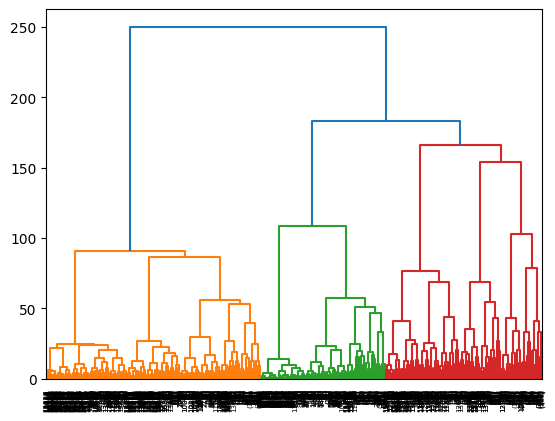

In [52]:
table = []
metric = "euclidean"
method = "ward"
truncation_mode = "level"
level = 10
k = 7

distances = pdist(df_numeric, metric=metric)
dlinkage = linkage(distances, metric=metric, method=method)
clusters = fcluster(dlinkage,k,criterion='maxclust')
current_silhouette = silhouette_score(df_numeric, clusters)
current_bouldin = metrics.davies_bouldin_score(df_numeric, clusters)
print(f"metric: {metric}, method:{method}, truncation_mode:{truncation_mode}, level':{level}, k:{k}, silhouette: {current_silhouette} , DBscore:{current_bouldin}")
dendrogram(dlinkage, truncate_mode=truncation_mode, p=level, leaf_rotation=90)
plt.show()
table.append({'metric':metric, 'method':method, 'truncation_mode': truncation_mode, 'level':level, 'k':k, 'silhouette': current_silhouette, 'DBscore':current_bouldin})


Final Model

In [56]:
n_clusters = len(np.unique(clusters))
# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(1, n_clusters + 1):
    occ_list.append(np.count_nonzero(np.array(clusters) == k))

print('cluster sizes:', occ_list)

cluster sizes: [3913, 445, 3134, 1155, 1746, 1540, 1909]


Plot of cluster labels distribution

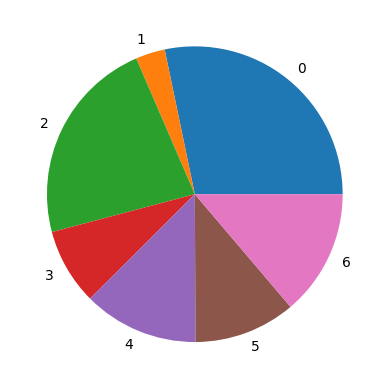

In [57]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

Involve_killing or not distribution

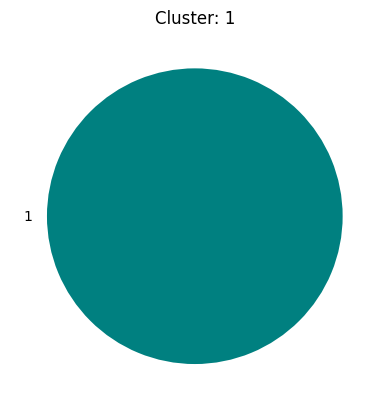

involve_killing
1    3913
Name: count, dtype: int64


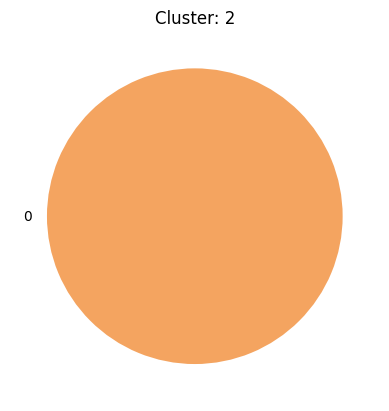

involve_killing
0    445
Name: count, dtype: int64


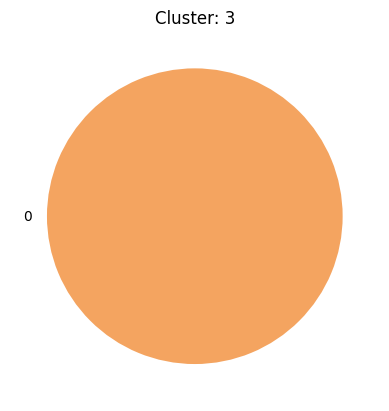

involve_killing
0    3134
Name: count, dtype: int64


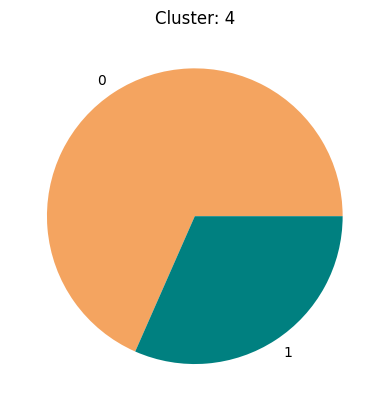

involve_killing
0    790
1    365
Name: count, dtype: int64


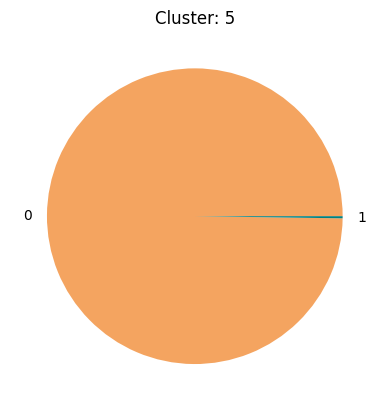

involve_killing
0    1742
1       4
Name: count, dtype: int64


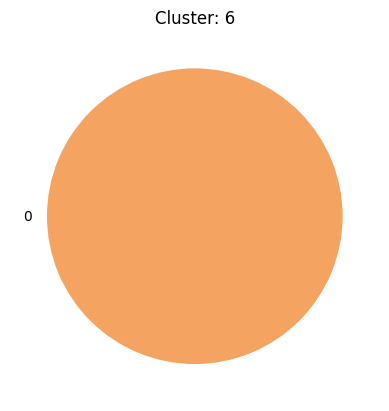

involve_killing
0    1540
Name: count, dtype: int64


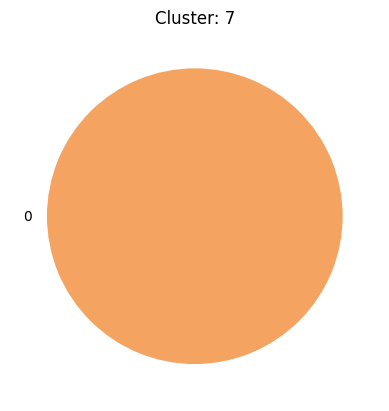

involve_killing
0    1909
Name: count, dtype: int64


In [55]:
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}

for k in range(1, n_clusters + 1):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_killing'].loc[np.array(clusters) == k].value_counts()
    # Show pie plot
    labels_class = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)